<a href="https://colab.research.google.com/github/mertkaya1033/MNIST_digit_classify/blob/master/MNIST_Classify_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Models


## Relevant Imports, Helpers and Backbone Classes

### Imports and Global Variables

In [14]:
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torchvision
import torchvision.transforms as T
from torchvision import datasets

from typing import Tuple, List, Union

MNIST_DATA_PATH = "data"
MNIST_IMAGE_SIZE = 28
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FIGSIZE = (20, 20)
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

### Helpers

#### Configuration Class for Training

In [15]:
# https://stackoverflow.com/questions/39832721/meaning-of-self-dict-self-in-a-class-definition
class Config(dict):
  """A class that allows attribute access and item access."""
  def __init__(self):
    self.__dict__ = self

#### Helpers for Visualization

In [16]:
def plot_encoded(encoded, labels=[], coloured=False, filename=None, s=1) -> None:
  """ Produce a scatter plot of the given points, and colour them according to
  the given labels. 
  
  Parameters:
    encoded (np.array)  --  points with shape (*, 2)
    labels (np.array)   --  label of each point, between 0 and 10. (default: [])
    coloured (boolean)  --  If True, assigns colour to each point according to 
                            their labels. (default: False)
    filename (str)      --  If not None, writes the produced figure to the filename
  """
  plots = []
  marker_size = plt.rcParams['lines.markersize']**2
  colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
             "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",]
  if coloured:
    for i in range(10):
      points = encoded[(labels == i)]
      xy = points.transpose(1, 0)
      plots.append((xy[0],xy[1]))
  else:
    xy = encoded.transpose(1, 0)
    plots.append((xy[0],xy[1]))

  plt.figure(figsize=FIGSIZE)
  for i, points in enumerate(plots):
    plt.scatter(points[0], points[1], c=colours[i], label=f"{i}", s=marker_size*s)
  plt.legend(fontsize='xx-large')
  if filename is not None:
    plt.savefig(filename)


def plot_losses(train_losses, valid_losses, filename=None, title="Loss"):
  """Plots the losses generated by Model Trainers"""
  plt.figure()
  plt.plot(train_losses, "ro-", label="Train")
  plt.plot(valid_losses, "go-", label="Validation")
  plt.legend()
  plt.title(title)
  plt.xlabel("Epochs")
  if filename is not None:
    plt.savefig(filename)


# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py
def show_images(imgs: Union[List, torch.Tensor], titles, filename=None) -> None:
  """ Shows images next to each other. 
  
  Parameters:
    imgs (Union[List, torch.Tensor]) --  An image or a List of images
    filename (str)            --  If not None, writes the produced figure to the
                                  filename
  """
  plt.rcParams["savefig.bbox"] = 'tight'
  if not isinstance(imgs, list):
      imgs = [imgs]
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=FIGSIZE)
  for i, img in enumerate(imgs):
    img = img.detach()
    img = T.functional.to_pil_image(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=titles[i])
  
  if filename is not None:
    fig.savefig(filename)


def make_grid_of_decoded(decoded_t, nrow=8):
  """Produces a grid of mnist image data.

  Parameters:
    decoded_t (torch.Tensor)  --  Batch of MNIST image data
    nrow (int)                --  Number of images displayed in each row of the
                                  grid. (default: 8)
  
  Returns:
    torch.Tensor              -- A grid of the images provided
  """
  decoded = decoded_t.view((-1, 1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)).detach().cpu()
  return torchvision.utils.make_grid(decoded, nrow=nrow)


def train_log(*args, f=None):
  print(*args)
  if f is not None:
    print(*args, file=f)

def get_coordinates_meshgrid(x_start, x_stop, x_num, y_start, y_stop, y_num):
  x_np = np.linspace(x_start, x_stop, num=x_num)
  y_np = np.linspace(y_start, y_stop, num=y_num)
  xx, yy = np.meshgrid(x_np, y_np)
  img_np = np.concatenate((xx[:,:, None], -yy[:,:,None]), axis=2).reshape((-1, 2))
  return img_np


### MNIST Data Handler

In [17]:
class MNIST_Data_Handler():
  """Downloads the MNIST dataset, and trains models that predict the handwritten
  digit written on the provided 28x28 image."""

  _training_data = None
  _test_data = None

  @classmethod
  def load_data(self, root: str = "data") -> Tuple[Dataset, Dataset]:
    """Downloads MNIST dataset into local file system, into the root directory. 
    Loads the dataset into memory.
    
    Parameters:
      root (str) -- the directory to download the dataset. (default: "data")
    
    Returns:
      tuple --  (training dataset, test dataset)
    """

    if self._training_data is None:
      self._training_data = datasets.MNIST(
          root=root,
          train=True,
          download=True,
          transform=T.ToTensor()
      )
    if self._test_data is None:
      self._test_data = datasets.MNIST(
          root=root,
          train=False,
          download=True,
          transform=T.ToTensor()
      )
    
    return self._training_data, self._test_data
  
  @classmethod
  def get_image_size(self) -> int:
    """Returns the size of the images in the dataset. -1 if data has not been loaded"""
    if self._training_data is None or self._test_data is None:
      return -1
    return self._training_data.data.size()[1]


### MNIST Model Trainer

In [18]:
class MNIST_Model_Trainer():
  """An Abstract class implementing basic required functions needed for every 
  trainer."""
  def _get_data(self):
    return MNIST_Data_Handler.load_data()

  def _get_loaders(self, train_data: Dataset, test_data: Dataset, args: Config, shuffle=False):
    train_dataloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=shuffle)
    return train_dataloader, test_dataloader

  def train_model(self, args: Config):
    raise NotImplementedError

## Classification

### Trainer: MNIST_Classify

In [19]:

class MNIST_Classify(MNIST_Model_Trainer):

  def train_model(self, args: Config):
    """Trains an instance of a model provided in args with the given hyperparameters
    for the task of classifying handwritten digits using the MNIST dataset.

    Parameters:
        args (Config) --  stores the model and the hyperparameters in which the 
                          model instance should be trained

    Returns:
        The trained model instance
    """
    if "log_filename" in args:
      log_file = open(args.log_filename, "w")
    else:
      log_file = None
    
    train_log("===================", args.experiment_name, "===================", f=log_file)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)

    train_log("Preparing Data...", f=log_file)
    train_data, test_data = self._get_data()
    train_dataloader, test_dataloader = self._get_loaders(train_data, test_data, args)
    
    num_digits = 10
    num_channels = 1
    image_size = MNIST_Data_Handler.get_image_size()

    mnist_model = args.Model(image_size, num_digits, num_channels, args).to(args.DEVICE)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=mnist_model.parameters(), lr=args.learn_rate)
    
    min_loss = -1
    train_losses = []
    val_losses = []
    val_accuracies = []

    early_stop_counter = 0
    early_stop_min = float("INF")

    train_log("Beginning Training...", f=log_file)
    start_time = time.time()
    for epoch in range(args.epochs):
      
      mnist_model.train()
      losses = []
      
      # Training
      for i, (input, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predictions = mnist_model(input.to(args.DEVICE))
        loss = loss_func(predictions, label.to(args.DEVICE))
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
      
      # Evaluate training loss of the epoch
      mnist_model.eval()
      avg_loss = np.mean(losses)
      train_losses.append(avg_loss)
      time_elapsed = time.time() - start_time
      train_log(f"Epoch [{epoch + 1}/{args.epochs}], Loss: {avg_loss:.4f}, Time(s): {time_elapsed:.2f}", f=log_file)

      # Performance with validation set
      correct = 0.0
      total = 0.0
      losses = []
      for i, (input, label) in enumerate(test_dataloader):
        label = label.to(args.DEVICE)
        input = input.to(args.DEVICE)
        predictions = mnist_model(input)
        loss = loss_func(predictions, label)
        losses.append(loss.data.item())
        _, predicted = torch.max(input=predictions.data, dim=1)
        correct += (predicted == label).sum()
        total += label.size(0)

      # Evaluate validation loss of the epoch
      val_loss = np.mean(losses)      
      val_acc = 100.0 * correct / total
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)

      time_elapsed = time.time() - start_time
      train_log(f"Epoch [{epoch + 1}/{args.epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}, Time(s): {time_elapsed:.2f}", f=log_file)

      # Keep track of validation loss to avoid overfitting
      if early_stop_min > val_loss:
        early_stop_counter = 0
        early_stop_min = val_loss
      else:
        early_stop_counter += 1

      if early_stop_counter >= 5:
        train_log(f"Validation loss has not improved for {early_stop_counter} epochs. Early Stop.", f=log_file)
        break

    train_log("Done.", f=log_file)
    train_log("=========================================================", f=log_file)
    log_file.close()
    return mnist_model, [train_losses, val_losses, val_accuracies]


### Model: Convolutional Neural Network 

This model consists of 2 convolution blocks, and a linear classifier. The convolution blocks are the following layers in sequence:
* Convolution layer
* Max pooling layer
* Batch Norm layer
* ReLU activation layer

In [20]:
class MNIST_CNN(nn.Module):
  """
  A convolutional neural network
  """
  def __init__(self, image_size, num_classes, num_in_channels, train_args) -> None:
      super().__init__()

      kernel = train_args.kernel
      num_filters = train_args.num_filters

      padding = kernel // 2

      self.convBlock1 = nn.Sequential(
          nn.Conv2d(
              in_channels=num_in_channels, 
              out_channels=num_filters,
              kernel_size=kernel,
              padding=padding),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(num_features=num_filters),
          nn.ReLU())
      
      self.convBlock2 = nn.Sequential(
          nn.Conv2d(
              in_channels=num_filters, 
              out_channels=num_filters,
              kernel_size=kernel,
              padding=padding),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(num_features=num_filters),
          nn.ReLU())
      
      self.flatten = nn.Flatten()

      in_features = (num_filters)*(image_size//4)*(image_size//4)

      self.linearBlock = nn.Sequential(
          nn.Linear(in_features=in_features, out_features=num_classes),
      )
      

  def forward(self, x):
    convolved1 = self.convBlock1(x)
    convolved2 = self.convBlock2(convolved1)
    flattened = self.flatten(convolved2)
    prediction = self.linearBlock(flattened)
    
      
    return prediction

### Training

mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘output/classification’: File exists
=================== MNIST_digit_classification_CNN ===================
Preparing Data...
Beginning Training...
Epoch [1/25], Loss: 0.1799, Time(s): 6.49
Epoch [1/25], Val Loss: 0.0563, Val Acc: 98.29, Time(s): 7.35
Epoch [2/25], Loss: 0.0483, Time(s): 13.67
Epoch [2/25], Val Loss: 0.0417, Val Acc: 98.60, Time(s): 14.53
Epoch [3/25], Loss: 0.0341, Time(s): 20.76
Epoch [3/25], Val Loss: 0.0340, Val Acc: 98.87, Time(s): 21.60
Epoch [4/25], Loss: 0.0266, Time(s): 28.43
Epoch [4/25], Val Loss: 0.0341, Val Acc: 98.88, Time(s): 29.27
Epoch [5/25], Loss: 0.0211, Time(s): 35.46
Epoch [5/25], Val Loss: 0.0340, Val Acc: 98.84, Time(s): 36.29
Epoch [6/25], Loss: 0.0167, Time(s): 42.49
Epoch [6/25], Val Loss: 0.0339, Val Acc: 98.75, Time(s): 43.32
Epoch [7/25], Loss: 0.0133, Time(s): 49.53
Epoch [7/25], Val Loss: 0.0335, Val Acc: 98.84, Time(s): 50.36
Epoch [8/25], Loss: 0.0107, 

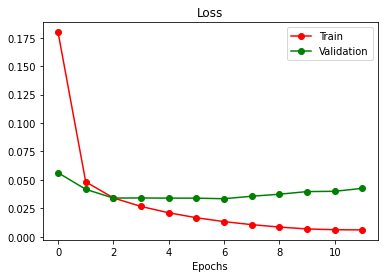

In [21]:
!mkdir output
!mkdir output/classification

cnn_args = Config()
cnn_args_dict = {
    "experiment_name": "MNIST_digit_classification_CNN",
    "Model": MNIST_CNN,
    "seed": 0,
    "epochs": 25,
    "learn_rate": 0.001,
    "batch_size": 128,
    "kernel": 5,
    "num_filters": 16,
    "DEVICE": DEVICE,
    "log_filename": "output/classification/MNIST_CNN_log.txt",
}
cnn_args.update(cnn_args_dict)

trainer = MNIST_Classify()
cnn_model, [train_losses, valid_losses, valid_accuracies] = trainer.train_model(cnn_args)
plot_losses(train_losses, valid_losses, filename="output/classification/MNIST_CNN_performance.png")

## Data Compression (Learning Manifold)

### Trainer: MNIST_AutoEncoder_Trainer

In [22]:
class MNIST_AutoEncoder_Trainer(MNIST_Model_Trainer):
  def train_model(self, args: Config):
    if "log_filename" in args:
      log_file = open(args.log_filename, "w")
    else:
      log_file = None

    train_log("===================", args.experiment_name, "===================", f=log_file)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
    train_log("Preparing Data...", f=log_file)
    train_data, test_data = self._get_data()
    train_dataloader, test_dataloader = self._get_loaders(train_data, test_data, args)
    
    image_size = MNIST_Data_Handler.get_image_size()

    mnist_model = args.Model(image_size=image_size).to(DEVICE)
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(params=mnist_model.parameters(), lr=args.learn_rate)
    
    min_loss = -1
    train_losses = []
    val_losses = []
    train_log("Beginning Training...", f=log_file)
    start_time = time.time()
    for epoch in range(args.epochs):
      
      mnist_model.train()
      losses = []
      
      # Training
      for i, (input, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        flattened_input = input.view((-1, image_size*image_size)).to(args.DEVICE)
        predictions = mnist_model(flattened_input)
        loss = loss_func(predictions, flattened_input)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
      
      mnist_model.eval()
      avg_loss = np.mean(losses)
      train_losses.append(avg_loss)
      time_elapsed = time.time() - start_time
      train_log(f"Epoch [{epoch + 1}/{args.epochs}], Loss: {avg_loss:.4f}, Time(s): {time_elapsed:.2f}", f=log_file)

      # Performance with validation set
      losses = []
      for i, (input, _) in enumerate(test_dataloader):
        flattened_input = input.view((-1, image_size*image_size)).to(args.DEVICE)
        predictions = mnist_model(flattened_input)
        loss = loss_func(predictions, flattened_input)
        losses.append(loss.data.item())

      val_loss = np.mean(losses)      
      val_losses.append(val_loss)
      
      time_elapsed = time.time() - start_time
      train_log(f"Epoch [{epoch + 1}/{args.epochs}], Val Loss: {val_loss:.4f}, Time(s): {time_elapsed:.2f}", f=log_file)
    train_log("Done.", f=log_file)
    train_log("=========================================================", f=log_file)
    return mnist_model, [train_losses, val_losses]

### Model: Deep AutoEncoder

In [23]:
# https://www.cs.toronto.edu/~hinton/science.pdf
class MNIST_AutoEncoder(nn.Module):
  def __init__(self, image_size=28) -> None:
    super().__init__()
  
    num_pixels = image_size*image_size

    self.encoder = nn.Sequential(
        nn.Linear(num_pixels, 1000),
        nn.Tanh(),
        nn.Linear(1000, 500),
        nn.Tanh(),
        nn.Linear(500, 250),
        nn.Tanh(),
        nn.Linear(250, 2),
        nn.Tanh(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(2, 250),
        nn.Tanh(),
        nn.Linear(250, 500),
        nn.Tanh(),
        nn.Linear(500, 1000),
        nn.Tanh(),
        nn.Linear(1000, num_pixels),
        nn.Sigmoid(),
    )
  
  def encode(self, flattened_img):
    return self.encoder(flattened_img)

  def decode(self, compressed):
    return self.decoder(compressed)

  def forward(self, flattened_img):
    return self.decode(self.encode(flattened_img))

### Training

mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘output/manifold’: File exists
=================== MNIST_AutoEncoder_Learning_Manifold ===================
Preparing Data...
Beginning Training...
Epoch [1/50], Loss: 0.0678, Time(s): 6.03
Epoch [1/50], Val Loss: 0.0586, Time(s): 6.84
Epoch [2/50], Loss: 0.0504, Time(s): 12.89
Epoch [2/50], Val Loss: 0.0472, Time(s): 13.71
Epoch [3/50], Loss: 0.0441, Time(s): 19.82
Epoch [3/50], Val Loss: 0.0430, Time(s): 20.63
Epoch [4/50], Loss: 0.0415, Time(s): 26.64
Epoch [4/50], Val Loss: 0.0419, Time(s): 27.46
Epoch [5/50], Loss: 0.0401, Time(s): 34.14
Epoch [5/50], Val Loss: 0.0406, Time(s): 34.95
Epoch [6/50], Loss: 0.0393, Time(s): 41.06
Epoch [6/50], Val Loss: 0.0400, Time(s): 41.86
Epoch [7/50], Loss: 0.0386, Time(s): 47.87
Epoch [7/50], Val Loss: 0.0404, Time(s): 48.66
Epoch [8/50], Loss: 0.0382, Time(s): 54.66
Epoch [8/50], Val Loss: 0.0389, Time(s): 55.46
Epoch [9/50], Loss: 0.0378, Time(s): 61.53
Epoch [9

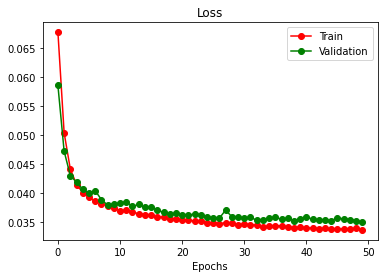

In [24]:
!mkdir output
!mkdir output/manifold

autoencoder_args = Config()
autoencoder_args_dict = {
    "experiment_name": "MNIST_AutoEncoder_Learning_Manifold",
    "Model": MNIST_AutoEncoder,
    "seed": 0,
    "epochs": 50,
    "learn_rate": 0.001,
    "batch_size": 128,
    # "pretrain": RBM,
    "DEVICE": DEVICE,
    "log_file": "output/manifold/MNIST_AutoEncoder.txt",
}
autoencoder_args.update(autoencoder_args_dict)

trainer = MNIST_AutoEncoder_Trainer()
autoencoder_model, [train_losses, valid_losses] = trainer.train_model(autoencoder_args)
plot_losses(train_losses, valid_losses, filename="output/manifold/MNIST_AutoEncoder_performance.png")

## Visualizations

To get a better understanding of the manifold learned by the autoencoder, we can visualize its outputs as a qualitative analysis.

#### Prepare Test Data

In [30]:
# Prepare Data
_, test_data = MNIST_Data_Handler.load_data()
data_ = (test_data.data.numpy() / 255.0).reshape((-1, 28*28))
targets_ = test_data.targets.numpy()

#### Test Images in 2D Space

By encode the test images using the manifold learned by the autoencoder, we can produce a scatter plot of the points the test images correspond to.


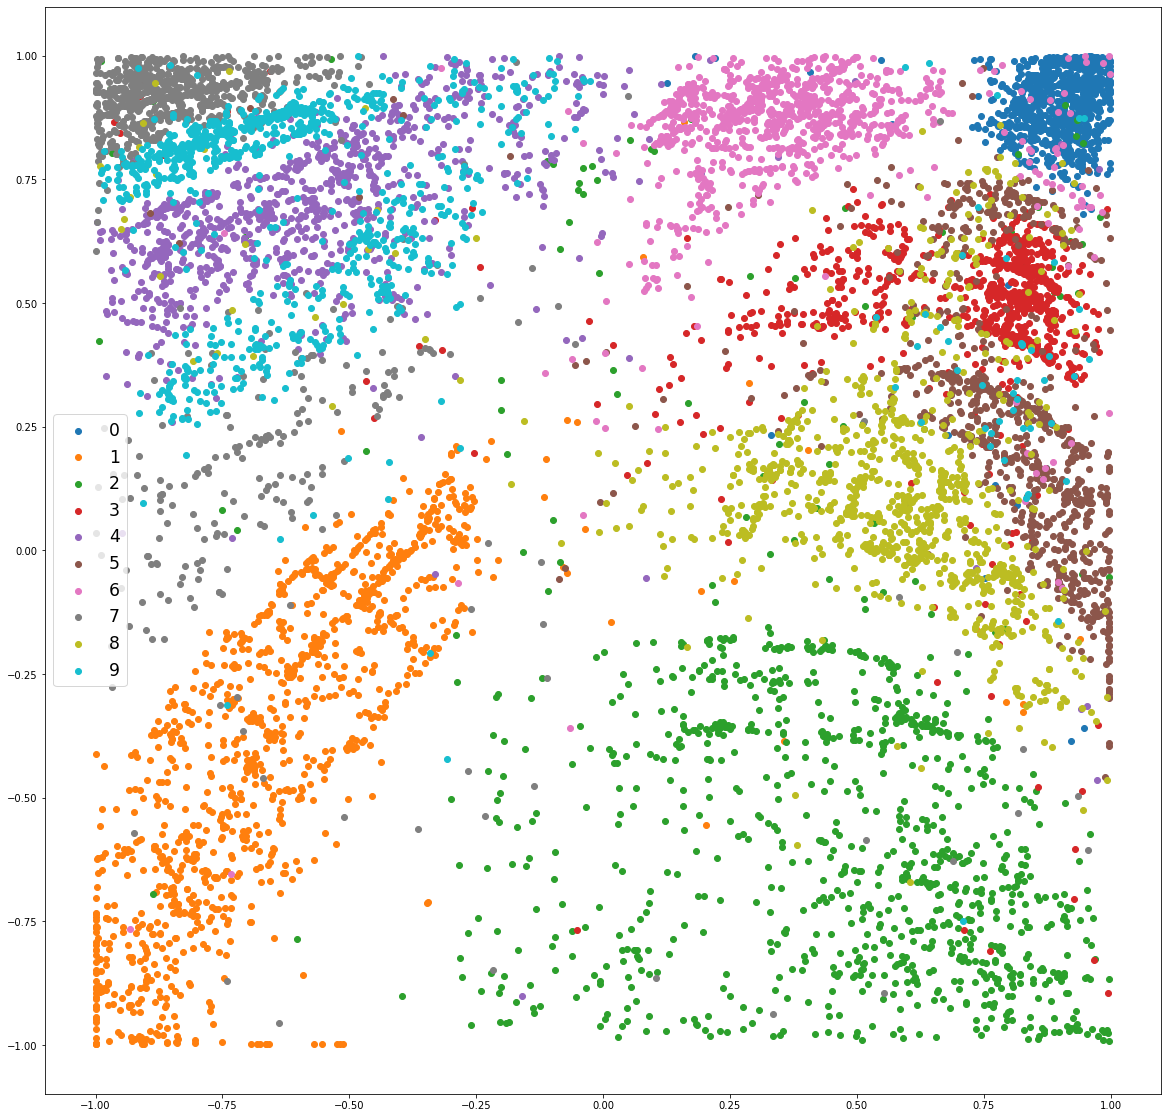

In [31]:
# Compute the corresponding 2D points of every test image
encoded_t = autoencoder_model.encode(torch.from_numpy(data_).to(torch.float32).to(DEVICE))
encoded = encoded_t.detach().cpu().numpy()

plot_encoded(encoded, targets_, coloured=True, filename="output/manifold/test_encoded_plot.png")

Even though the autoencoder was trained in an unsupervised fashion (i.e. with no labels provided), the images of the same digits tend to form a cluster in the 2D space. This implies that the autoencoder was able to pick up the patterns between the same hand-written digits and differences between different hand-written digits.

#### AutoEncoder's Ability to Reconstruct Images

One of the main usecases of autoencoders are data compression. To see if any of the important details have gotten lost, or any details that changes the way we classify each image has been added, we can reconstruct some of the images and compare them to their originals.

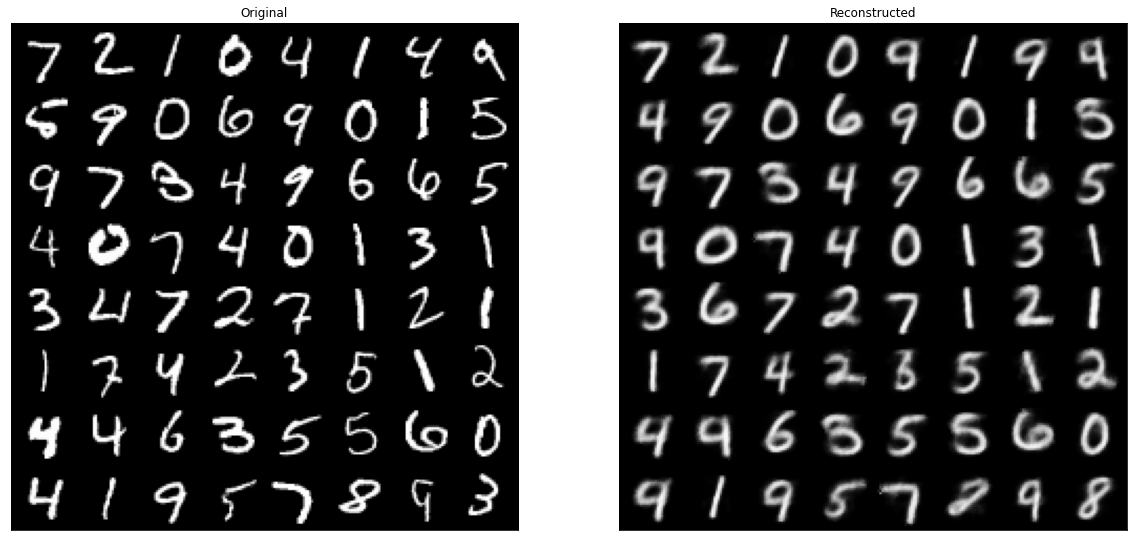

In [32]:
# Choose the first 64 encoded test images, reconstruct them and produce a 8x8 grid
to_reconstruct_t = encoded_t[:64]
reconstructed_t = autoencoder_model.decode(to_reconstruct_t)
reconstructed_grid = make_grid_of_decoded(reconstructed_t)

# Get the corresponding original 64 images and produce a grid
original_t = torch.from_numpy(data_).to(torch.float32)[:64]
original_grid = make_grid_of_decoded(original_t)

show_images([original_grid, reconstructed_grid], titles=["Original", "Reconstructed"], filename="output/manifold/test_orig_vs_reconstructed.png")

The autoencoder has managed to decently reconstruct the images given the fact that their dimensions were reduced to 2.

#### Encoder's Range

Due to the hyperbolic tangent activation, the range of the encoder is $x\in[-1, 1], y\in[-1, 1]$. Therefore, we can visualize the autoencoder's distinctions between the digits, and how the continuous change between different digits' images occur.

In [33]:
# To visualize how the images change over decoder's  2D domain:
# get a grid of evenly spaced 32*32=1024 points, x\in[-1, 1], y\in[-1, 1]
images_32x32_np = get_coordinates_meshgrid(-1.0, 1.0, 32, -1.0, 1.0, 32)
images_32x32_t = torch.from_numpy(images_32x32_np).to(torch.float32)
# Get the corresponding images and produce a 32x32 grid
images_decoded_32x32_t = autoencoder_model.decode(images_32x32_t.to(DEVICE))
images_grid_32x32 = make_grid_of_decoded(images_decoded_32x32_t, nrow=32)

The plot of the points to reconstruct:

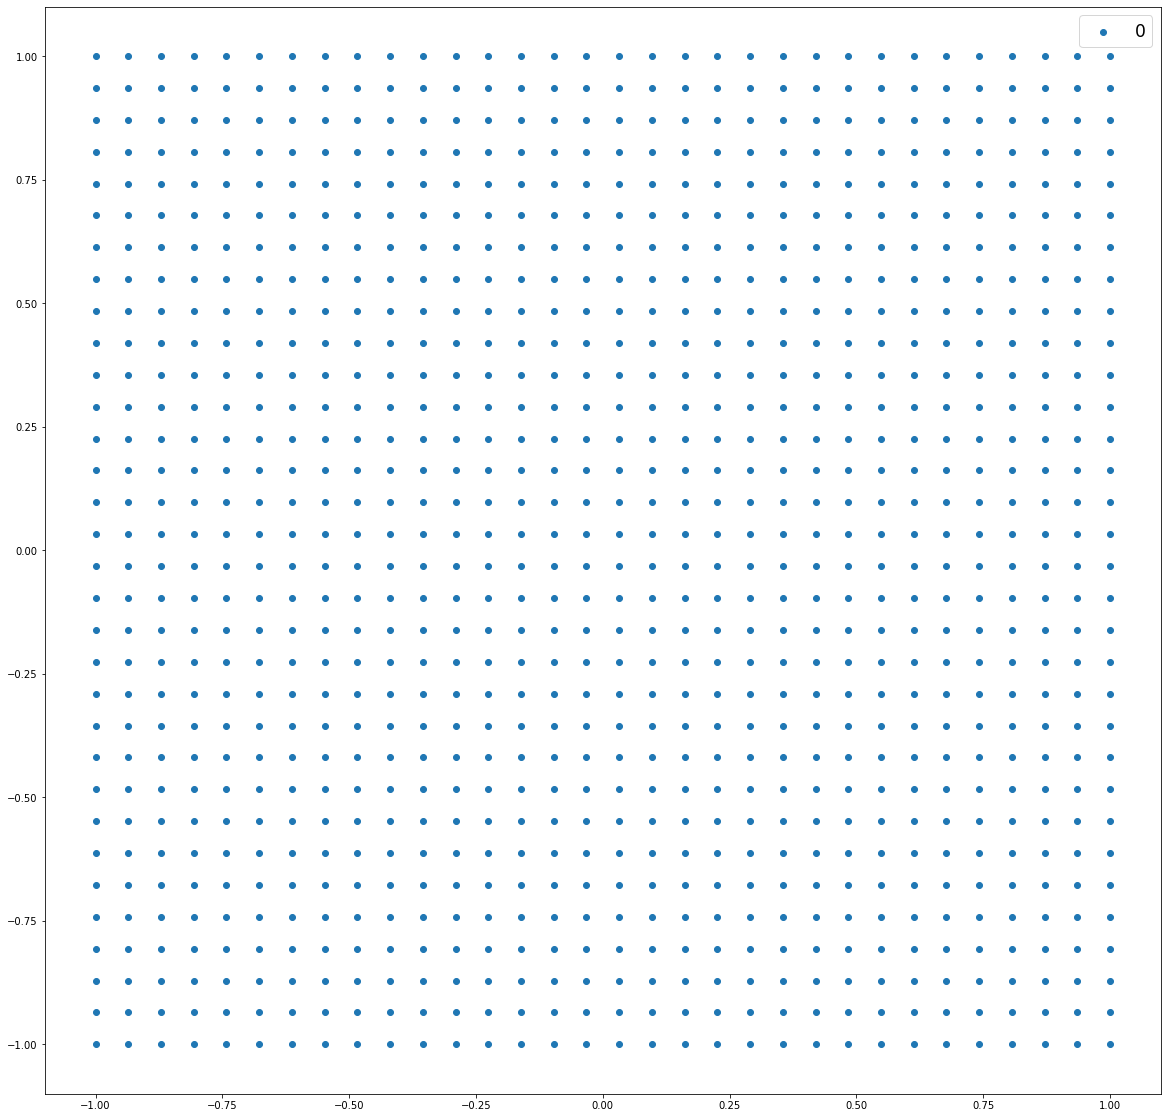

In [34]:
plot_encoded(images_32x32_t, [], coloured=False, filename="output/manifold/uniform_sample_plot.png")

The reconstructions:

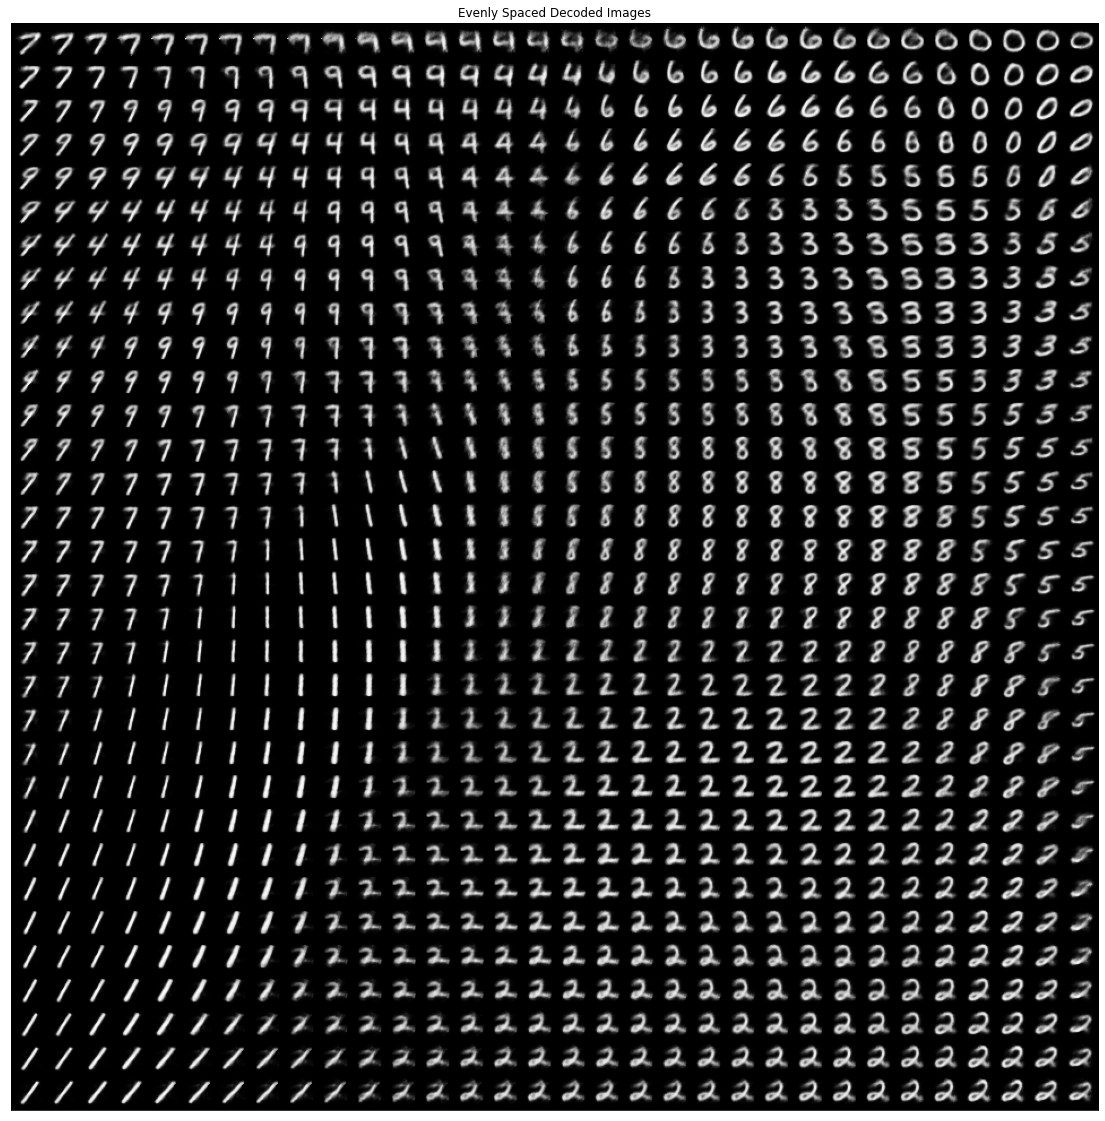

In [35]:
show_images(images_grid_32x32, titles=["Evenly Spaced Decoded Images"], filename="output/manifold/uniform_sample_decoded.png")

#### Distribution of digits over 2D space

Previously, we have trained a CNN model on the hand-written digit classification task. We can utilize this model to visualize the distribution of the digits. 

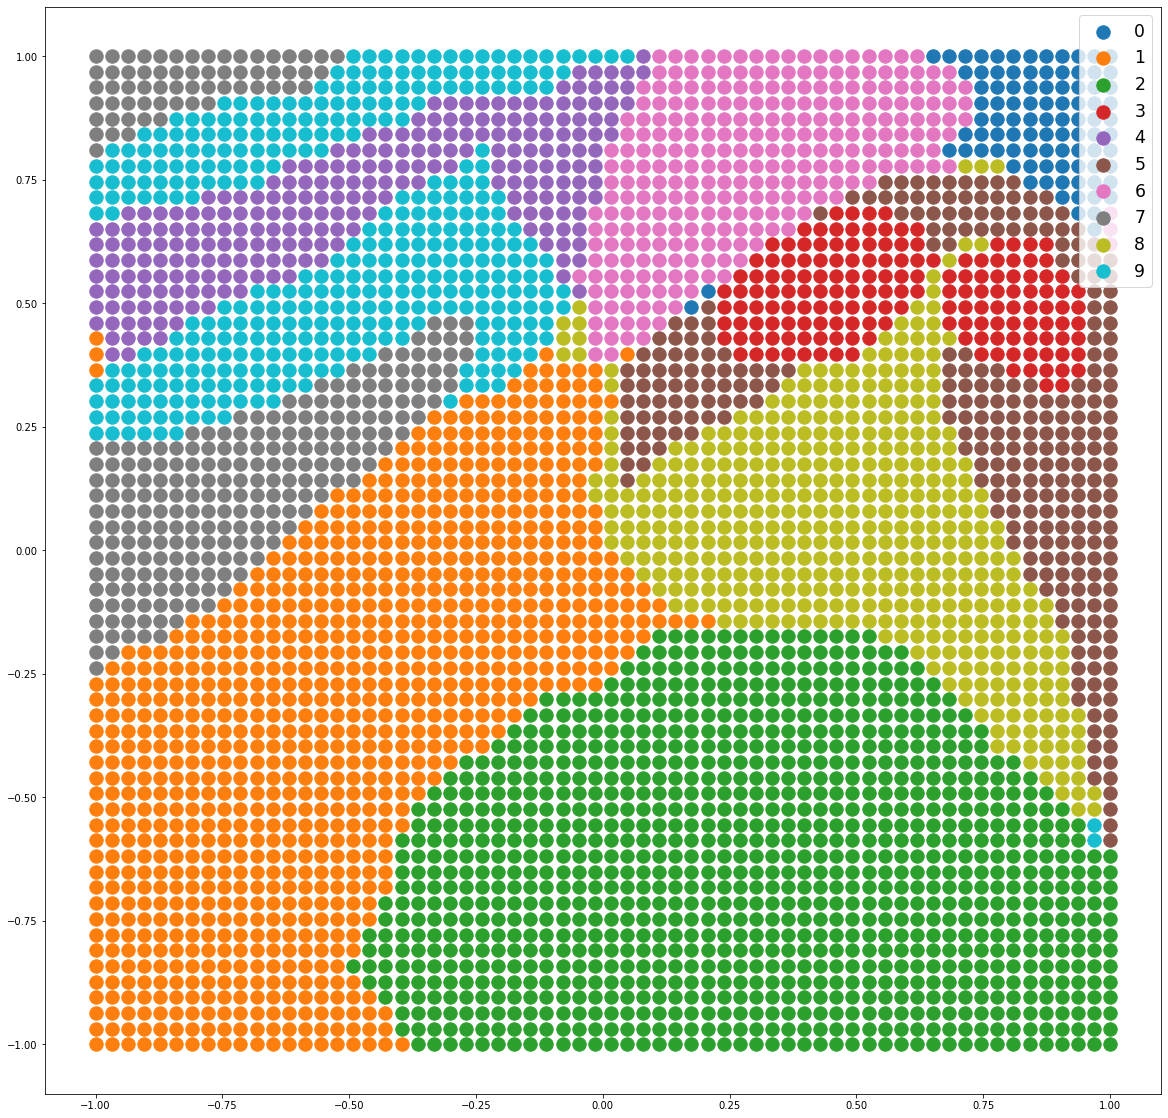

In [36]:
# To visualize how the digits occupy decoder's  2D domain (utilizing the classification model):
# get a grid of evenly spaced 64*64=4096 points, x\in[-1, 1], y\in[-1, 1]
images_64x64_np = get_coordinates_meshgrid(-1.0, 1.0, 64, -1.0, 1.0, 64)
images_64x64_t = torch.from_numpy(images_64x64_np).to(torch.float32)
images_decoded_64x64_t = autoencoder_model.decode(images_64x64_t.to(DEVICE))

cnn_predictions_t = cnn_model(images_decoded_64x64_t.view((-1, 1, 28, 28)))
cnn_predictions_np = cnn_predictions_t.detach().cpu().numpy().argmax(axis=1)

plot_encoded(images_64x64_np, cnn_predictions_np, coloured=True, filename="output/manifold/digit_distribution_over_2D.png", s=5)

# Other

In [37]:
DOWNLOAD_OUTPUT = True

if DOWNLOAD_OUTPUT:
  !zip -r /content/output.zip /content/output/
  files.download("/content/output.zip")

updating: content/output/ (stored 0%)
updating: content/output/manifold/ (stored 0%)
updating: content/output/manifold/test_orig_vs_reconstructed.png (deflated 6%)
updating: content/output/manifold/MNIST_AutoEncoder_performance.png (deflated 7%)
updating: content/output/manifold/uniform_sample_decoded.png (deflated 7%)
updating: content/output/manifold/test_encoded_plot.png (deflated 2%)
updating: content/output/manifold/uniform_sample_plot.png (deflated 60%)
updating: content/output/manifold/trial.png (deflated 27%)
updating: content/output/classification/ (stored 0%)
updating: content/output/classification/MNIST_CNN_performance.png (deflated 6%)
updating: content/output/classification/MNIST_CNN_log.txt (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>